```markdown
# Visualisation
```

In [2]:
#functions
import networkx as nx
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import FancyArrowPatch, Circle
import torch
def compute_tour_length(x, tour,remove_start_token=True,get_tour_only=True,get_cumulative=False): 
    """
    Compute the length of a batch of tours
    Inputs : x of size (bsz, city_count+1, 2) batch of tsp tour instances
             tour of size (bsz, city_count) batch of sequences (node indices) of tsp tours
    Output : L of size (bsz,)             batch of lengths of each tsp tour
    """
    if remove_start_token:
        x = x[:,:-1,:]
    bsz = x.shape[0]
    arange_vec = torch.arange(bsz, device=x.device).unsqueeze(-1)
    tour = tour.to(x.device)

    # Get the cities in the order of the tour
    ordered_cities = x[arange_vec, tour, :] # size(ordered_cities)=(bsz, city_count, 2)

    # Compute the differences between each pair of consecutive cities
    diffs = ordered_cities[:, 1:, :] - ordered_cities[:, :-1, :] # size(diffs)=(bsz, city_count-1, 2)

    # Compute the distance between each pair of consecutive cities
    distances = torch.sqrt(torch.sum(diffs**2, dim=2)) # size(distances)=(bsz, city_count-1)

    # Add the distance from the last city to the first
    distances = torch.cat([distances, torch.norm(ordered_cities[:, 0, :] - ordered_cities[:, -1, :], dim=1).unsqueeze(-1)], dim=1)
    # Sum the distances to get the total length of each tour
    L = torch.sum(distances, dim=1)
    if get_cumulative:
        L = torch.cumsum(distances,dim=1).mean(0)
    if get_tour_only:
        return L
    #this will both return the tour and the length
    else:
        return L, distances

def plot_tsp(x_coord, tours, probability=None, plot_dist_pair=False,save=None,circle_draw=False):
    """
    Helper function to plot a single TSP problem with four different tours.
    
    Args:
    x_coord (numpy.ndarray): Coordinates of cities, shape (n, 2)
    tours (list): List of 4 tours, each tour is a list/array of city indices
    probability (list, optional): List of 4 lists, each containing probabilities for the edges in the corresponding tour
    plot_dist_pair (bool): Whether to plot pairwise distances
    """
    names=['Mamba','Transformer','Optimal','Greedy']
    tours = [tour.tolist() for tour in tours]
    # Ensure x_coord is numpy array
    x_coord = np.array(x_coord)
    nb_nodes = x_coord.shape[0]
    
    # Create a graph
    G = nx.Graph()
    pos = dict(zip(range(nb_nodes), x_coord.tolist()))
    
    if plot_dist_pair:
        dist_pair = squareform(pdist(x_coord, metric='euclidean'))
        G = nx.from_numpy_array(dist_pair)
    else:
        G.add_nodes_from(range(nb_nodes))  # Ensure nodes are added to the graph
    
    # Create a 1x4 subplot
    fig, axs = plt.subplots(1, 3, figsize=(20, 7))
    axs = axs.ravel()
    
    for i, tour in enumerate(tours):
        if i==3:
            break
        # Compute tour length
        length = sum(np.linalg.norm(x_coord[tour[j]] - x_coord[tour[j-1]]) for j in range(nb_nodes))
        
        # Create edge list for the tour
        edges = list(zip(tour, tour[1:] + [tour[0]]))
        
        # Colors for nodes
        colors = ['b'] * nb_nodes  # Default color blue
        node_sizes = [30] * nb_nodes  # Default node size
        if i != 2:
            colors[tour[0]] = 'g'  # Green for the first node of the tour
            node_sizes[tour[0]] = 120  # Larger size for the first node
        
        # Plot nodes
        nx.draw_networkx_nodes(G, pos, ax=axs[i], node_color=colors, node_size=node_sizes)
        
        # Plot edges with arrows and probabilities if provided
        for j, (u, v) in enumerate(edges):
            if i != 2:
                axs[i].add_patch(FancyArrowPatch(posA=pos[u], posB=pos[v], arrowstyle='->', color='r', mutation_scale=26, lw=1.5))
            else:
                axs[i].plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], color='r')
            
            if probability is not None and probability[i] is not None:
                prob = probability[i][j]
                mid_point = (np.array(pos[u]) + np.array(pos[v])) / 2
                axs[i].text(mid_point[0], mid_point[1], f'{prob:.2f}', fontsize=12, color='black',alpha=0.6)
        
        if plot_dist_pair:
            nx.draw_networkx_edges(G, pos, ax=axs[i], alpha=0.08, width=0.5)
        
        axs[i].set_title(f'Tour {names[i]}: Length = {length:.3f}', fontsize=25)
        axs[i].axis('off')

        if circle_draw:
            # Create a circle
            circle = Circle((0.5, 0.5), 0.3, edgecolor='yellow', facecolor='yellow', alpha=0.3)

            # Add the circle to the plot
            axs[i].add_patch(circle)

            # Set the limits of the plot
            axs[i].set_xlim(0, 1)
            axs[i].set_ylim(0, 1)

            # Remove labels and legend
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            axs[i].legend().set_visible(False)
    
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()

In [3]:
#generate data functions 
def generate_normal_data(device, batch_size, city_count, coord_dim=2 , start = 2):
    #The value of start will signify the start of the decoding phase
    random_data = torch.randn(batch_size, city_count, coord_dim).to(device)
    random_data /= 5
    random_data = random_data + 0.5
    start_data = torch.full((batch_size, 1, coord_dim), start).to(device)
    return torch.cat((random_data, start_data), dim=1)

def generate_clustered_data(device, batch_size, city_count, coord_dim=2, start=2):
    # The value of start will signify the start of the decoding phase
    random_data_full = torch.zeros(batch_size, city_count, coord_dim).to(device)
    num_clusters = 3
    points_per_cluster = city_count // num_clusters
    cluster_std_dev = 0.05  # Reduced standard deviation for tighter clusters

    for i in range(num_clusters):
        center = torch.rand(batch_size, 1, coord_dim).to(device)
        print(center[0])
        random_data = torch.randn(batch_size, points_per_cluster, coord_dim).to(device) * cluster_std_dev
        if i == num_clusters - 1:
            points_per_cluster_new = city_count - i * points_per_cluster
            random_data = torch.randn(batch_size, points_per_cluster_new, coord_dim).to(device) * cluster_std_dev
        random_data = random_data + center
        if i != num_clusters - 1:
            random_data_full[:, i * points_per_cluster:(i + 1) * points_per_cluster, :] = random_data
        else:
            random_data_full[:, i * points_per_cluster:i * points_per_cluster + points_per_cluster_new, :] = random_data
        
    start_data = torch.full((batch_size, 1, coord_dim), start).to(device)
    return torch.cat((random_data_full, start_data), dim=1)


def generate_quad_points(device, batch_size, city_count,quad = 'tl'):
    # Generate random points for the entire tensor
    points = torch.rand(batch_size, city_count, 2).to(device)
    if quad =='tl':
        # Create a mask for points in the 0-0.25 quadrant
        mask = (points[:, :, 0] <= 0.5) & (points[:, :, 1] >= 0.5)
        points[mask] += torch.tensor([0.5,0]).to(device)
    else:
        mask = (points[:, :, 0] >= 0.5) & (points[:, :, 1] <= 0.5)
        points[mask] += 0.5
    
    
    start_data = torch.full((batch_size, 1, 2), 2).to(device)
    return torch.cat((points, start_data), dim=1)


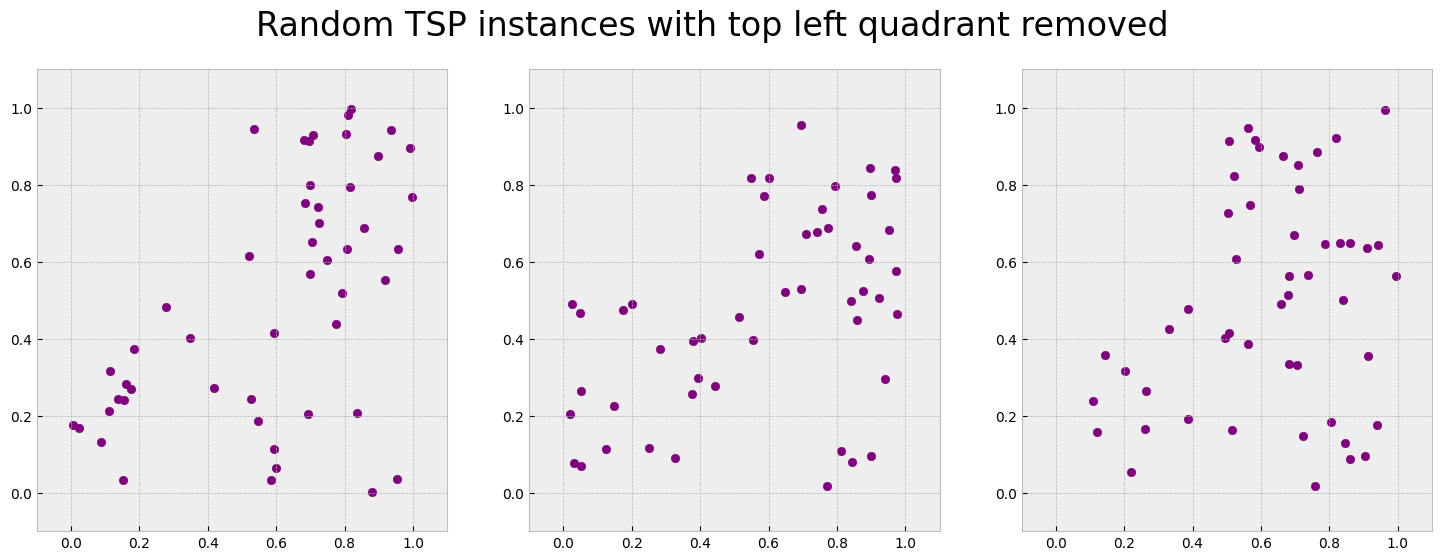

In [9]:
import torch
import matplotlib.pyplot as plt

# Define the device
device = 'cpu'
plt.style.use('bmh')

# Parameters
batch_size = 1
city_count = 50
coord_dim = 2
start = 2
torch.manual_seed(0)

# Generate data
quad_data = generate_quad_points(device, batch_size, city_count)
quad_data2 = generate_quad_points(device, batch_size, city_count)
quad_data3 = generate_quad_points(device, batch_size, city_count)

# Convert data to CPU for plotting
quad_data_cpu = quad_data.squeeze(0).cpu().numpy()
quad_data_cpu2 = quad_data2.squeeze(0).cpu().numpy()
quad_data_cpu3 = quad_data3.squeeze(0).cpu().numpy()

# Exclude the start city
quad_data_cpu_excl_start = quad_data_cpu[:-1]
quad_data_cpu_excl_start2 = quad_data_cpu2[:-1]
quad_data_cpu_excl_start3 = quad_data_cpu3[:-1]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

# Plot clustered data excluding start city
axs[0].scatter(quad_data_cpu_excl_start[:, 0], quad_data_cpu_excl_start[:, 1], c='purple', label='Clustered Data')
axs[1].scatter(quad_data_cpu_excl_start2[:, 0], quad_data_cpu_excl_start2[:, 1], c='purple', label='Clustered Data')
axs[2].scatter(quad_data_cpu_excl_start3[:, 0], quad_data_cpu_excl_start3[:, 1], c='purple', label='Clustered Data')

# Set the same x and y limits for all subplots
for ax in axs:
    ax.set_xlim(-0.1,1.1 )
    ax.set_ylim(-0.1,1.1)

# Set a universal title
fig.suptitle('Random TSP instances with top left quadrant removed', fontsize=24)

plt.savefig('mamba/evals/figs/custom_data_quad.pdf',bbox_inches='tight')
plt.show()

tensor([[0.1628, 0.0004]], device='cuda:0')
tensor([[0.6001, 0.8215]], device='cuda:0')
tensor([[0.5411, 0.3487]], device='cuda:0')
[torch.Size([1, 50]), torch.Size([1, 50])]
[torch.Size([1, 50]), torch.Size([1, 50])]
torch.Size([50, 2])
Problem Name: 7a821911bd624714bf1ca049be4c00e4
Problem Type: TSP
Number of Nodes: 50
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Setting kick type to close
Starting Cycle: 599
   0 Steps   Best: 569   0.00 seconds
   2 Steps   Best: 568   0.01 seconds
  25 Total Steps.
Best cycle length: 568
Lin-Kernighan Running Time: 0.05
LK Initial Run: 568.0
LK Run 0: 568.0
LK Run from best tour: 568.0
Time to find compression tour: 0.20 (seconds)
Set initial upperbound to 568 (from tour)
Fractional Matching: 483.5
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.00 (seconds)
Setting upperbound to the initial

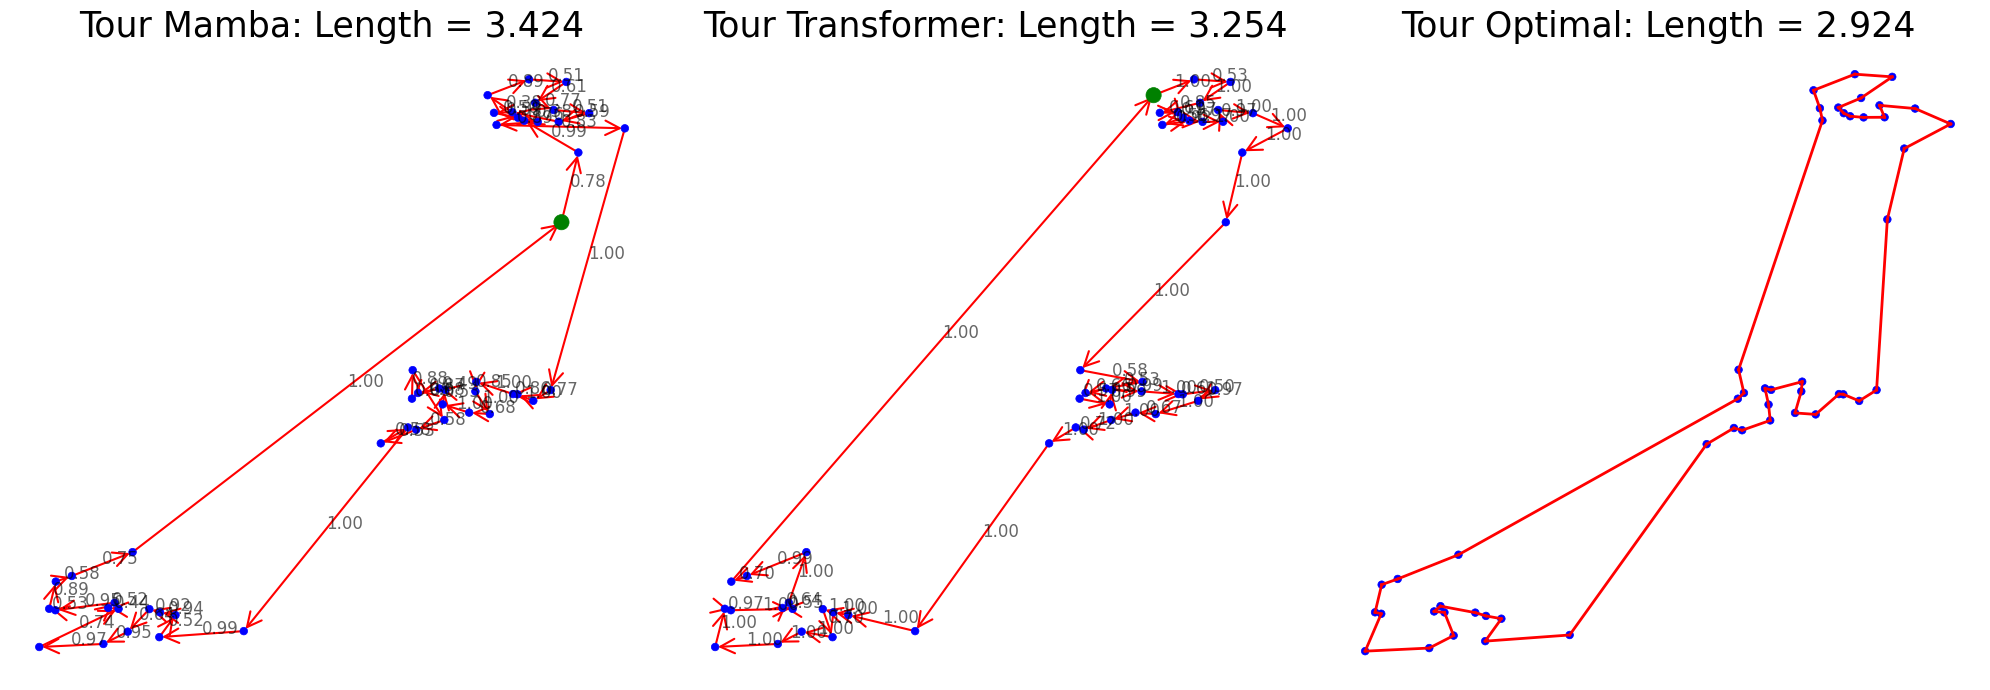

In [7]:
#Visualise the tours
from benchmarks.pyconcorde.concorde.tsp import TSPSolver
import pandas as pd
import numpy as np
import torch
from benchmarks.benchmark_solvers import greedy_tsp
import torch
from model import seq2seq_generate_tour,MambaFull, compute_tour_length
from benchmarks.transformer_model import TSP_net

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.style.use('bmh')
# Parameters
batch_size = 1
city_count = 50
coord_dim = 2
start = 2

def create_concorde_tour(test_data):
    x_coord_i = test_data.cpu().numpy()
    graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]
    solver = TSPSolver.from_data(graph.lat, graph.lon, norm="GEO")
    solution = solver.solve()
    return torch.tensor(solution.tour)

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

torch.manual_seed(94)
#Create Test Set
clustered_data = generate_clustered_data(device, 1, city_count, coord_dim, start)
quad_data = generate_quad_points(device, 1, city_count)

checkpoint = torch.load('mamba/checkpoints/big/BIG_city50_2.pt')
transformer_checkpoint = torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl')

transformer_model = TSP_net(2, 128, 512, 6, 2, 8, 1000,True).to(device)
transformer_model.eval()

Loss_mamba = [] #(10000) (10000)
Loss_transformer = [] #(10000) (10000)
tours_mamba = [] #(10000,50) (10000,50)
tours_transformer = [] #(10000,50) (10000,50)
prob_of_action_mamba = [] #(10000,50) (10000,50)
prob_of_action_transformer = [] #(10000,50) (10000,50)


args = checkpoint['args']
model = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls,args.B, args.reverse,args.reverse_start,args.mamba2,args.last_layer).to(device)
model.load_state_dict(checkpoint['model_baseline_state_dict'])
model.eval()
transformer_model.load_state_dict(transformer_checkpoint['model_baseline'])
transformer_model.eval()

with torch.no_grad():
	for data in [clustered_data,quad_data]:
		tours ,Logprobofactions = seq2seq_generate_tour(device,model,data,deterministic=True,lastlayer=args.last_layer,sum_logactions=False)
		tours_mamba.append(tours)
		prob_of_action_mamba.append(torch.stack(Logprobofactions, dim=0))
		Loss_mamba.append(compute_tour_length(data,tours))

		data = data[:,:-1,:]
		tours, Logprobofactions = transformer_model(data,True,sum_logactions=False)
		tours_transformer.append(tours)
		prob_of_action_transformer.append(torch.stack(Logprobofactions, dim=0))
		Loss_transformer.append(compute_tour_length(data,tours,remove_start_token=False))

print([i.shape for i in tours_mamba])
print([i.shape for i in tours_transformer])

saveloc = None
#i {0:clustered,1:quad}, j (batch index)
i,j = 0,0
data = [clustered_data,quad_data][i][j][:-1]
print(data.shape)
plot_tsp(data.cpu(), 
        [tours_mamba[i][j], tours_transformer[i][j], create_concorde_tour(data)],
        [torch.exp(prob_of_action_mamba[i][:,j]), torch.exp(prob_of_action_transformer[i][:,j]), None],save=saveloc)

In [9]:
#Run generalistation test set on mamba and transformer
clustered_data = torch.load('mamba/data/generalisation/clustered_data.pt')
quad_data = torch.load('mamba/data/generalisation/quad_data.pt')

Loss_mamba = [] #(2000) (2000)
Loss_transformer = [] #(2000) (2000)
tours_mamba = [] #(2000,50) (2000,50) 
tours_transformer = [] #(2000,50) (2000,50) 
prob_of_action_mamba = [] #(2000,50) (2000,50)
prob_of_action_transformer = [] #(2000,50) (2000,50) 

with torch.no_grad():
	for data in [clustered_data,quad_data]:
		tours ,Logprobofactions = seq2seq_generate_tour(device,model,data,deterministic=True,lastlayer=args.last_layer,sum_logactions=False)
		tours_mamba.append(tours)
		prob_of_action_mamba.append(torch.stack(Logprobofactions, dim=0))
		Loss_mamba.append(compute_tour_length(data,tours))

		data = data[:,:-1,:]
		tours, Logprobofactions = transformer_model(data,True,sum_logactions=False)
		tours_transformer.append(tours)
		prob_of_action_transformer.append(torch.stack(Logprobofactions, dim=0))
		Loss_transformer.append(compute_tour_length(data,tours,remove_start_token=False))

torch.save(Loss_mamba,'mamba/data/generalisation/mamba.pt')
torch.save(Loss_transformer,'mamba/data/generalisation/transformer.pt')

In [12]:
Loss_mamba = torch.load('mamba/data/generalisation/mamba.pt')
Loss_transformer = torch.load('mamba/data/generalisation/transformer.pt')
Loss_optimal = [torch.load('mamba/data/generalisation/clustered_data_labels.pt'),torch.load('mamba/data/generalisation/quad_data_labels.pt')]

print([i.mean() for i in Loss_mamba])
print([i.mean() for i in Loss_transformer])
print([i.mean() for i in Loss_optimal])

[tensor(3.3855, device='cuda:0'), tensor(5.5024, device='cuda:0')]
[tensor(3.0695, device='cuda:0'), tensor(5.0065, device='cuda:0')]
[tensor(3.0487, device='cuda:0'), tensor(4.9732, device='cuda:0')]


[tensor(13.4776), tensor(10.6769)]
[tensor(2.8529), tensor(0.6699)]


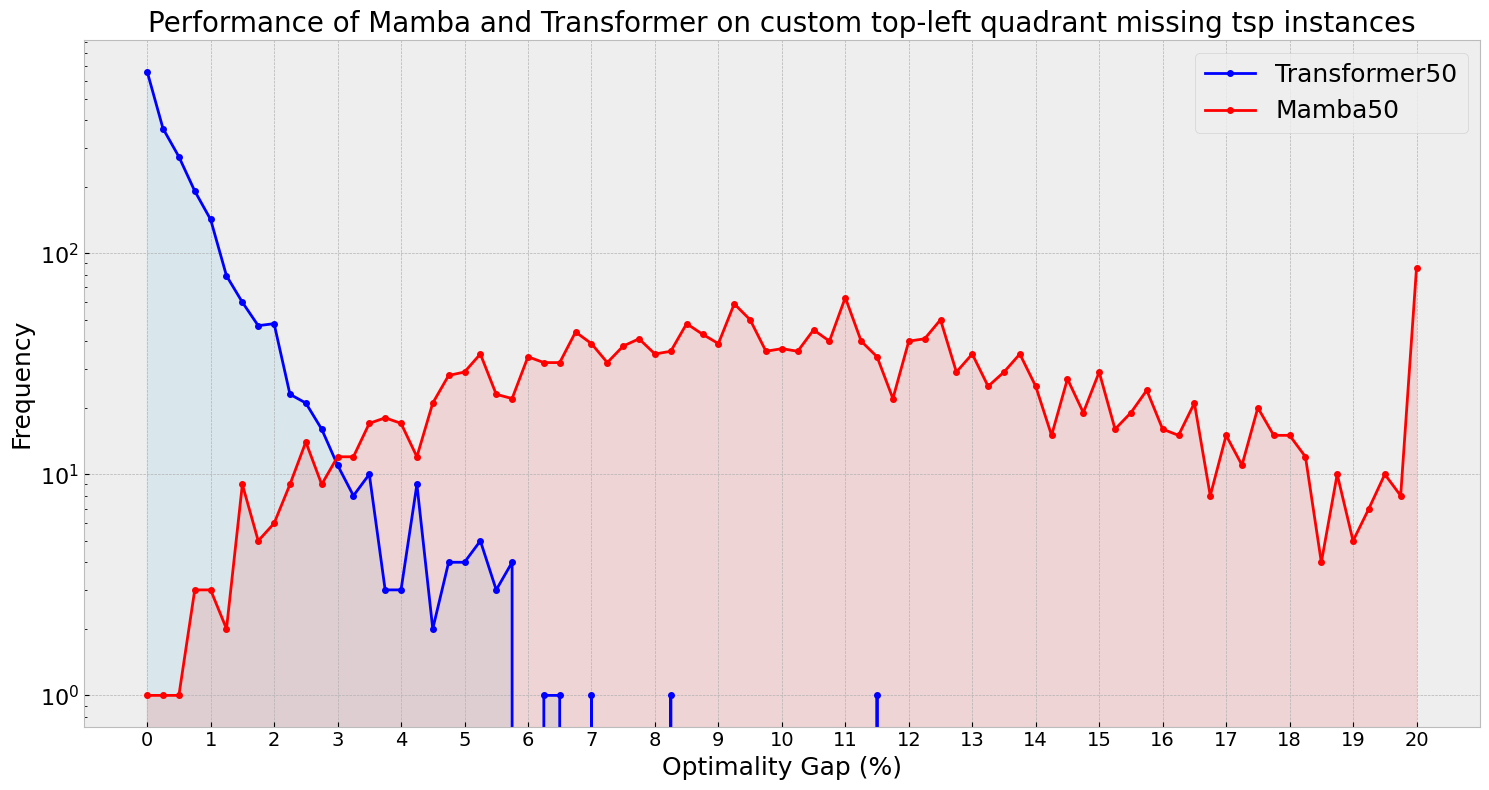

In [20]:
#Create histogram of tour lengths
import numpy as np
import matplotlib.pyplot as plt
import torch

Loss_mamba = torch.load('mamba/data/generalisation/mamba.pt',map_location=torch.device('cpu'))
Loss_transformer = torch.load('mamba/data/generalisation/transformer.pt',map_location=torch.device('cpu'))
test_data_labels = [torch.load('mamba/data/generalisation/clustered_data_labels.pt',map_location=torch.device('cpu')),torch.load('mamba/data/generalisation/quad_data_labels.pt',map_location=torch.device('cpu'))]

#Convert loss to optimality gap
for i in range(2):
    Loss_mamba[i] = (Loss_mamba[i] - test_data_labels[i])*100/test_data_labels[i]
    Loss_transformer[i] = (Loss_transformer[i] - test_data_labels[i])*100/test_data_labels[i]

plt.style.use('bmh')

print([i.mean() for i in Loss_mamba])
print([i.mean() for i in Loss_transformer])

for i in range(1):
    # Define custom bin edges according to the specification
    bin_edges = np.concatenate([
        [-np.inf],  # For bin 0
        np.arange(0.125, 20, 0.25),  # For bins 1 to second last
        [np.inf]  # For the last bin
    ])

    # Create histogram data
    #hist1, _ = np.histogram(Loss_transformer[i].cpu().numpy(), bins=bin_edges)
    #hist2, _ = np.histogram(Loss_mamba[i].cpu().numpy(), bins=bin_edges)

    i+=1

    hist3, _ = np.histogram(Loss_transformer[i].cpu().numpy(), bins=bin_edges)
    hist4, _ = np.histogram(Loss_mamba[i].cpu().numpy(), bins=bin_edges)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 8))

    # Set the positions of the points on the x-axis
    r = np.arange(len(hist1))

    # Create the line chart
    # Plot the 50 variant
    #ax.plot(r, hist1, marker='o', markersize=4, color='blue', label='Transformer clustered')
    #ax.plot(r, hist2, marker='o', markersize=4, color='red', label='Mamba clustered')
    ax.plot(r, hist3, marker='o', markersize=4, color='blue', label='Transformer50',)
    ax.plot(r, hist4, marker='o', markersize=4, color='red', label='Mamba50')
    #ax.fill_between(r, hist1,color='blue', alpha=0.3)
    #ax.fill_between(r, hist2,color='red', alpha=0.12)
    ax.fill_between(r, hist3,color='lightblue', alpha=0.32)
    ax.fill_between(r, hist4,color='lightcoral', alpha=0.23)

    # Customize the plot
    ax.set_xlabel('Optimality Gap (%)', fontsize=18)
    ax.set_ylabel('Frequency', fontsize=18)
    ax.set_title(f'Performance of Mamba and Transformer on custom top-left quadrant missing tsp instances', fontsize=20)

    # Identify the bins corresponding to whole numbers and set the labels
    whole_number_bins = [0] + [int((x + 0.125) * 4) for x in range(1, 20)] + [len(bin_edges) - 2]
    whole_number_labels = list(range(21))
    
    ax.set_xticks(whole_number_bins)
    ax.set_xticklabels(whole_number_labels, fontsize=14)
    plt.yticks(fontsize=16)
    
    ax.legend(fontsize=18)
    ax.set_yscale('log')
    ax.x_lim = (0, 20)

    # Adjust layout and show the plot
    plt.tight_layout()

    # Uncomment to save the plot
    save_loc = f'mamba/evals/figs/custom_hist.pdf'
    plt.savefig(save_loc, bbox_inches='tight')

    plt.show()

In [ ]:
'''#Find optimal tours for the generalisation test set
clustered_data = torch.load('mamba/data/generalisation/clustered_data.pt')[:,:-1,:]
quad_data = torch.load('mamba/data/generalisation/quad_data.pt')[:,:-1,:]

Loss_optimal = [] #(2000) (2000)

clustered_tours = []
quad_tours = []

for i in range(2000):
    clustered_tours.append(create_concorde_tour(clustered_data[i]))
    quad_tours.append(create_concorde_tour(quad_data[i]))

clustered_tours = torch.stack(clustered_tours)
quad_tours = torch.stack(quad_tours)

print(clustered_data.shape)
print(clustered_tours.shape)

clustered_loss = compute_tour_length(clustered_data,clustered_tours,remove_start_token=False)
quad_loss = compute_tour_length(quad_data,quad_tours,remove_start_token=False)

torch.save(clustered_loss,'mamba/data/generalisation/clustered_data_labels.pt')
torch.save(quad_loss,'mamba/data/generalisation/quad_data_labels.pt')'''


In [110]:
'''#create generalisation test set
torch.manual_seed(94)
#Create Test Set
clustered_data = generate_clustered_data(device, 2000, city_count, coord_dim, start)
quad_data = generate_quad_points(device, 2000, city_count)

torch.save(clustered_data,'mamba/data/generalisation/clustered_data.pt')
torch.save(quad_data,'mamba/data/generalisation/quad_data.pt')
'''

tensor([[0.1628, 0.0004]], device='cuda:0')
tensor([[0.5070, 0.5414]], device='cuda:0')
tensor([[0.5654, 0.6368]], device='cuda:0')
